# Importing libraries
Just importing some libraries. Also, before you try to run this notebook, make sure the dataset is on the same folder!

In [62]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os 

import matplotlib.pyplot as plt
from matplotlib.image import imread

import numpy as np

import scipy

import torch
import torch.nn.functional as F

from torch import optim
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

# Data split, augmentation and loaders
Now we're going to visualize the data and define the loaders! Since we only have a training and test set, we're gonna split the latter on testing and validation set. We're also going to apply transforms to the data so better train the model!

In [63]:
mean = [0.485, 0.456, 0.406];
std = [0.229, 0.224, 0.225];

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([transforms.Resize(330),
                               transforms.RandomCrop(300),   
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomRotation(24),
                               transforms.ToTensor(),
                               transforms.Normalize(mean = mean, std = std)])

# choose the training and test datasets
total_data =  datasets.ImageFolder('staticmap', transform=transform)

num_workers = 0
batch_size = 64
valid_size = 0.5      # percentage of training set to use as validation


# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([transforms.Resize(330),
                                transforms.CenterCrop(300),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = mean, std = std)])

# choose the training and test datasets
train_data =  datasets.ImageFolder('staticmap/train', transform=transform)
test_data =  datasets.ImageFolder('staticmap/test', transform=transform)


# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)


# specify the image classes
classes = ["industrial", "residential"]


# Data visualization

In [64]:
# helper function to un-normalize and display an image
def imshow(img):
    for idx, channel in enumerate(img):   # we use a custom 'mean' and 'std'. Therefore, we need to loop through each channel and unnormalize properly
        img[idx] = ((img[idx] * std[idx]) + mean[idx])
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

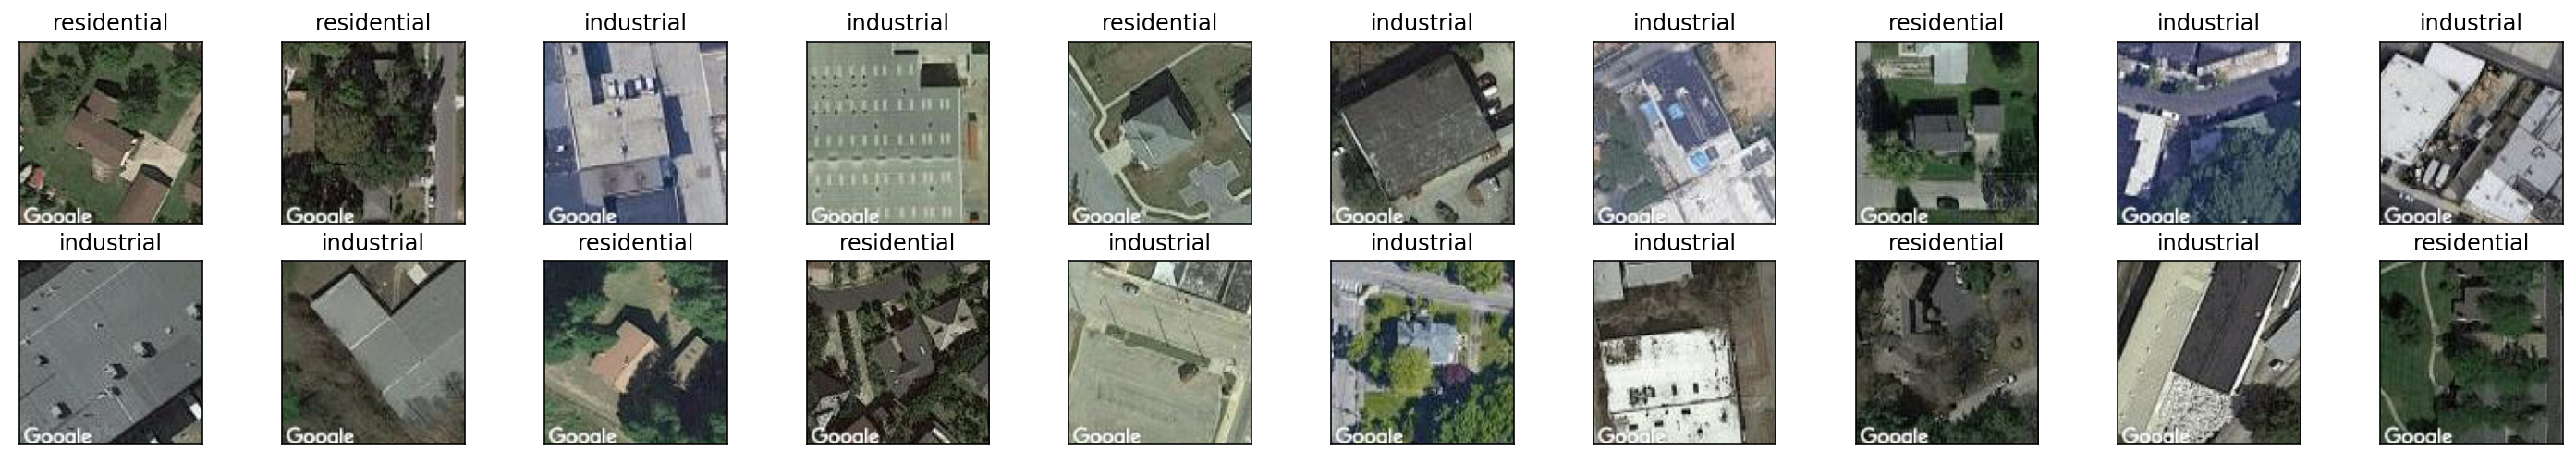

In [65]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

# Create model

For this example, we'll be using the [Wide ResNet architecture](https://pytorch.org/hub/pytorch_vision_wide_resnet/), already pre-trained. For this, we want to change the classifier with our own and we need to know the number of nodes so we can output 2 classes, as our problem suggests.

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [67]:
model = models.wide_resnet50_2(pretrained = True)

In [68]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# Define new classifier
classifier = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.3),
                                 nn.Linear(512, 2),
                                 nn.LogSoftmax(dim=1))

model.fc = classifier

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr = 0.001)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

# Train the model

We're going to train the model now. We'll have a validation loop to track if we're overfitting or not.

In [69]:
# Name of the model export
name_model = "model_residential_v_industrial_classifier.pt"

# Number of epochs to train the model
n_epochs = 20

# Track change in validation loss
valid_loss_min = np.Inf 

train_losses_array, validation_losses_array = [], []
for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    valid_loss = 0.0
    
    # TRAINING THE MODEL
    model.train()
    for data, target in train_loader:
        
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*data.size(0)
        
    # VALIDATION
    model.eval()
    for data, target in valid_loader:

        data, target = data.to(device), target.to(device)

        output = model(data)
        loss = criterion(output, target)

        valid_loss += loss.item()*data.size(0)
    
    # Calculating the average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    # Adding losses to array to plot later
    train_losses_array.append(train_loss/len(train_loader))
    validation_losses_array.append(valid_loss/len(valid_loader))
        
    # Printing training/validation information per epoch 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # Saving model if validation loss has decreased from last iteration
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), name_model)
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.728660 	Validation Loss: 0.525838
Validation loss decreased (inf --> 0.525838).  Saving model ...
Epoch: 2 	Training Loss: 0.463106 	Validation Loss: 0.418825
Validation loss decreased (0.525838 --> 0.418825).  Saving model ...
Epoch: 3 	Training Loss: 0.376237 	Validation Loss: 0.412517
Validation loss decreased (0.418825 --> 0.412517).  Saving model ...
Epoch: 4 	Training Loss: 0.376250 	Validation Loss: 0.396760
Validation loss decreased (0.412517 --> 0.396760).  Saving model ...
Epoch: 5 	Training Loss: 0.390826 	Validation Loss: 0.352773
Validation loss decreased (0.396760 --> 0.352773).  Saving model ...
Epoch: 6 	Training Loss: 0.344381 	Validation Loss: 0.366727
Epoch: 7 	Training Loss: 0.287636 	Validation Loss: 0.353909
Epoch: 8 	Training Loss: 0.297783 	Validation Loss: 0.372803
Epoch: 9 	Training Loss: 0.318566 	Validation Loss: 0.386348
Epoch: 10 	Training Loss: 0.294749 	Validation Loss: 0.367268
Epoch: 11 	Training Loss: 0.268445 	Validation Lo

In [70]:
model.load_state_dict(torch.load(name_model))

<All keys matched successfully>

# Testing the accuracy

Now we'll use the testing dataset to test the accuracy of our trained model.

In [71]:
# Track test loss
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

model.eval()
for data, target in test_loader:
    data, target = data.to(device), target.to(device)

    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    
    # Convert output probabilities to predicted class
    _, prediction = torch.max(output, 1)    
    
    # Compare predictions to true label
    correct_tensor = prediction.eq(target.data.view_as(prediction))
    
    # Convert the output into a numpy array
    if device == 'cuda': 
        correct = np.squeeze(correct_tensor.numpy())
    else:
        correct = np.squeeze(correct_tensor.cpu().numpy())
    
    # Calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# Average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.218784

Test Accuracy of industrial: 97% (146/150)
Test Accuracy of residential: 87% (131/150)

Test Accuracy (Overall): 92% (277/300)


# Output visualization

Visualizing the training and validating loss and check if we're overfitting the model or not. We need to reach the sweet spot where both training loss and validation loss have met. If they've yet to do so, we can try to increase the learning rate, tinker with data augmentation and hyperparameters.



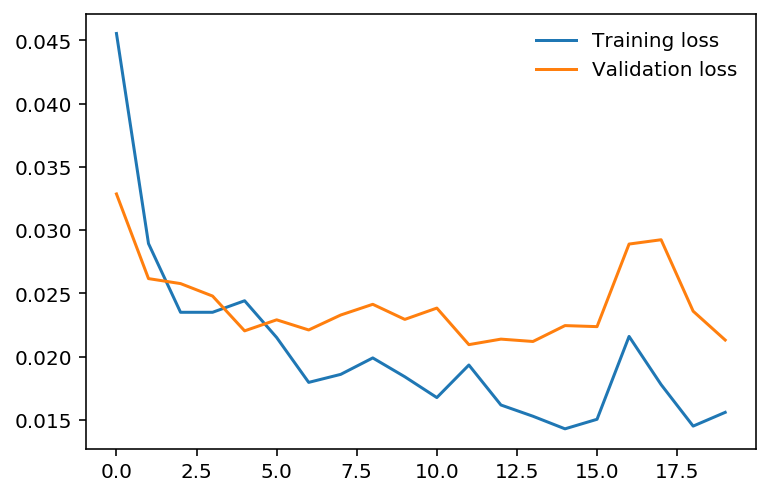

In [72]:
plt.plot(train_losses_array, label='Training loss')
plt.plot(validation_losses_array, label='Validation loss')
plt.legend(frameon=False)